<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Implementation" data-toc-modified-id="Implementation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Implementation</a></span></li><li><span><a href="#Using-implicit.bpr.BayesianPersonalizedRanking()" data-toc-modified-id="Using-implicit.bpr.BayesianPersonalizedRanking()-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Using <code>implicit.bpr.BayesianPersonalizedRanking()</code></a></span><ul class="toc-item"><li><span><a href="#K-Core-Pruning" data-toc-modified-id="K-Core-Pruning-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>K-Core Pruning</a></span></li><li><span><a href="#Sparse-User-Item-Matrix" data-toc-modified-id="Sparse-User-Item-Matrix-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Sparse User-Item Matrix</a></span></li></ul></li><li><span><a href="#Similarity-Measure" data-toc-modified-id="Similarity-Measure-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Similarity Measure</a></span><ul class="toc-item"><li><span><a href="#Implementation" data-toc-modified-id="Implementation-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Implementation</a></span><ul class="toc-item"><li><span><a href="#Item-Item-Similarity-Measure" data-toc-modified-id="Item-Item-Similarity-Measure-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Item-Item Similarity Measure</a></span></li><li><span><a href="#User-Item-Similarity-Measure" data-toc-modified-id="User-Item-Similarity-Measure-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>User-Item Similarity Measure</a></span></li><li><span><a href="#사용자-취향-분석" data-toc-modified-id="사용자-취향-분석-3.1.3"><span class="toc-item-num">3.1.3&nbsp;&nbsp;</span>사용자 취향 분석</a></span><ul class="toc-item"><li><span><a href="#성별에-따른-취향" data-toc-modified-id="성별에-따른-취향-3.1.3.1"><span class="toc-item-num">3.1.3.1&nbsp;&nbsp;</span>성별에 따른 취향</a></span></li><li><span><a href="#나이에-따른-취향" data-toc-modified-id="나이에-따른-취향-3.1.3.2"><span class="toc-item-num">3.1.3.2&nbsp;&nbsp;</span>나이에 따른 취향</a></span></li></ul></li></ul></li><li><span><a href="#Using-annoy" data-toc-modified-id="Using-annoy-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Using <code>annoy</code></a></span><ul class="toc-item"><li><span><a href="#Item-Item-Similarity-Measure" data-toc-modified-id="Item-Item-Similarity-Measure-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Item-Item Similarity Measure</a></span></li><li><span><a href="#User-Item-Similarity-Measure" data-toc-modified-id="User-Item-Similarity-Measure-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>User-Item Similarity Measure</a></span></li></ul></li></ul></li></ul></div>

In [1]:
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.sparse import csr_matrix
from implicit.bpr import BayesianPersonalizedRanking as BPR
import pickle as pk
from sklearn.deyosition import PCA
from annoy import AnnoyIndex
from google_drive_downloader import GoogleDriveDownloader as gdd
import os

np.set_printoptions(3)
plt.style.use("dark_background")

In [167]:
artists = pd.read_csv("./Datasets/Last.fm/artists.csv")
users = pd.read_csv("./Datasets/Last.fm/users.csv")
gdd.download_file_from_google_drive(file_id="1BpEbW6iSUlIp7zr3s_KDaeIRMUjgpSlV", dest_path="D:/plays.csv")
plays = pd.read_csv("D:/plays.csv")

id2name = {row["artist_id"]:row["artist_name"] for _, row in artists.iterrows()}
plays.insert(2, "artist", plays["artist_id"].apply(lambda x:id2name[x]))

- 재생 횟수를 별점으로 해석하면 안 됩니다.
- 그 이유는 데뷔한 지 오래되거나 발표한 곡이 많을수록 해당 아티스트의 재생 횟수는 일반적으로 많을 수밖에 없기 때문입니다.
- BPR에서는 재생 횟수를 그대로 사용하는 것이 아니라 재생 여부만을 봅니다.
- 이때 재생한 적 있는 아티스트를 재생한 적 없는 아티스트보다 선호한다는 가정을 깔고 갑니다.
- BPR은 긍정 아이템과 부정 아이템 간의 랭킹의 차이를 objective function으로 하여 그 값이 커지도록 embedding합니다.

# Implementation

In [60]:
# 데이터의 크기를 줄입니다.
top_users = plays["user_id"].value_counts()[:100].index
top_artists = plays["artist_id"].value_counts()[:100].index

plays_top = plays[(plays["user_id"].isin(top_users)) & (plays["artist_id"].isin(top_artists))]

# plays_top["user_id"] = pd.Categorical(plays_top["user_id"])
# plays_top["artist_id"] = pd.Categorical(plays_top["artist_id"])

# plays_top["user_id"] = plays_top["user_id"].cat.codes
# plays_top["artist_id"] = plays_top["artist_id"].cat.codes

In [61]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

all_artists = set(artists["artist_id"])
user_artist = plays.groupby(["user_id"])["artist_id"].apply(frozenset)

# Initialize embedding vectors.
dim = 10
# user_embs = np.random.normal(size=(len(users), dim + 1))
# item_embs = np.random.normal(size=(len(artists), dim + 1))
user_embs = np.random.normal(size=(len(users), dim + 1))
item_embs = np.random.normal(size=(len(artists), dim + 1))

lr = 0.1
n_epochs = 12
# reg = 0.01
for epoch in tqdm(range(1, n_epochs + 1)):
    hist = []
    for _, row in plays_top.iterrows():
        # Normalization
#         user_emb = user_embs/np.linalg.norm(user_embs, axis=1)[:, np.newaxis]
#         art_emb = item_embs / np.linalg.norm(item_embs, axis=1)[:, np.newaxis]
        
        user = row["user_id"]
        user_vec = user_embs[user]
        
        # User가 좋아하는 아이템
        pos_item = row["artist_id"]
        pos_item_vec = item_embs[pos_item]
        
        # User가 좋아하지 않는 아이템
        user_not_artist = all_artists - user_artist[user]
        neg_item = random.choice(list(user_not_artist))
        neg_item_vec = item_embs[neg_item]
        
        cos_sim_pos = np.dot(user_vec, pos_item_vec)/(np.linalg.norm(user_vec, ord=2)*np.linalg.norm(pos_item_vec, ord=2))
        cos_sim_neg = np.dot(user_vec, neg_item_vec)/(np.linalg.norm(user_vec, ord=2)*np.linalg.norm(neg_item_vec, ord=2))
        
        diff = cos_sim_pos - cos_sim_neg
        z = sigmoid(diff)
        loss = -np.log(z)
        
        user_embs[user] -= lr*(z - 1)*(pos_item_vec - neg_item_vec)
        item_embs[pos_item] -= lr*(z - 1)*user_vec
        item_embs[neg_item] -= -lr*(z - 1)*user_vec
                
        corr = (z>=0.6)
        hist.append(corr)
#         hist.append(loss)
    acc = sum(hist)/len(hist)
    print(f"epoch: {epoch:>3d} | acc: {acc:5.1%}")
#     print(f"epoch: {epoch:>3d} | loss: {loss:5.5%}")
    
    if acc >= 0.95:
        break

epoch:   1 | acc: 17.1%
epoch:   2 | acc: 24.5%
epoch:   3 | acc: 30.9%
epoch:   4 | acc: 38.1%
epoch:   5 | acc: 45.8%
epoch:   6 | acc: 55.8%
epoch:   7 | acc: 70.3%
epoch:   8 | acc: 78.8%
epoch:   9 | acc: 87.1%
epoch:  10 | acc: 89.8%
epoch:  11 | acc: 92.7%
epoch:  12 | acc: 95.1%



In [ ]:
# id2name = {row["artist_id"]:row["artist_name"] for _, row in artists.iterrows()}

# item_embs = pd.DataFrame(item_embs, index=[id2name[i] for i in plays_top["artist_id"].cat.categories])

# Using `implicit.bpr.BayesianPersonalizedRanking()`

## K-Core Pruning
- 모든 유저의 재생 횟수 데이터를 이용해서 추천 시스템을 만든다고 좋은 것은 아닙니다. 소수의 아티스트만 고집해서 듣는 유저와, 소수의 유저만이 듣는 아티스트 데이터는 Matrix factorization을 통해 올바르게 임베딩을 하기 어렵습니다. 이렇게 적은 정보를 가진 유저와 아티스트들은 특정 값으로 편향될 우려가 있기 때문에, 모델의 학습이 일반화되지 못할 우려가 있습니다. 따라서 적절한 기준을 가지고 편향을 발생시킬 우려가 있는 샘플은 제거해야 합니다.
- 이때 K-core Pruning을 통해 K명 이상의 유저가 들은 아티스트와 K명 이상의 아티스트의 음악을 들은 유저만 남깁니다.

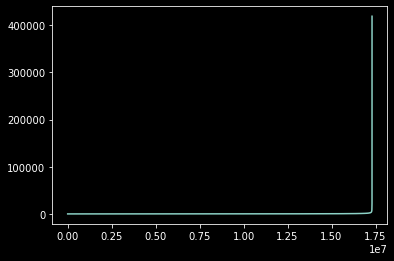

In [3]:
plays["plays"].sort_values().reset_index(drop=True).plot.line();

In [62]:
# `plays`가 전체 `plays`의 하위 10% 초과인 레코드만 남깁니다. 이 경우에만 각 사용자가 각 아시트를 좋아한다고 판단하는 것입니다.
likes = plays[plays["plays"]>plays["plays"].quantile(0.1)]

thr = 5
len_prev = -1
len_next = -2
while len_prev != len_next:
    len_prev = len(likes)
    print(f"len(likes): {len(likes):,}")
    
    # `thr`명보다 많은 수의 아티스트의 음악을 들은 사용자
    user_n_artists = likes["user_id"].value_counts()
    users_ = user_n_artists[user_n_artists>thr].index
    
    # `thr`명보다 많은 수의 사용자가 음악을 들은 아티스트
    artist_n_users = likes["artist_id"].value_counts()
    artists_ = artist_n_users[artist_n_users>thr].index

    likes = likes[(likes["user_id"].isin(users_)) & (likes["artist_id"].isin(artists_))]
    len_next = len(likes)
print("Finished!")

len(likes): 15,494,436
len(likes): 15,306,742
len(likes): 15,305,394
len(likes): 15,305,294
Finished!


- `likes`에 포함되지 않은 사용자와 아티스트는 추천 시스템을 만들기 위한 Matrix Factorization 대상에서 제외됩니다.
- 이처럼 초기 정보가 부족해서 추천 시스템을 제공하지 못하는 사용자와 아티스트가 발생하는 문제를 Cold Start라 합니다.
- 이러한 사용자 또는 아티스트에게는 다른 추천 시스템을 제공해야 합니다.

## Sparse User-Item Matrix
- sparse representation으로 표현된 dense matrix를 그대로 ndarray로 변환하면 메모리의 낭비가 극심하므로 sparse matrix로 변환하는 것이 필요합니다.
- scipy.sparse의 csr_matrix는 데이터와 인덱스를 따로 저장함으로써 그것을 실현하는 방법입니다.

In [63]:
# Label encoding
likes["user_id"] = pd.Categorical(likes["user_id"])
likes["artist_id"] = pd.Categorical(likes["artist_id"])

vals = likes["plays"]
rows = likes["artist_id"].cat.codes.values
cols = likes["user_id"].cat.codes.values

ui_sparse = csr_matrix((vals, (rows, cols)))

In [64]:
file = "D:/bpr_model_implicit.pkl"
gdd.download_file_from_google_drive(file_id="1wymLSbx0jFecHUmI_EDLNNF0sP_T_y-3", dest_path=file)
if os.path.exists(file):
    print("Loading...")
    with open(file, "rb") as f:
        model = pk.load(f)
else:
    with open(file, "wb") as f:
        # Embedding vector에는 마지막에 bias가 하나씩 붙어서 크기가 `factors + 1`이 됩니다.
        model = BPR(factors=60)
        model.fit(ui_sparse)
        print("Saving...")
        pk.dump(model, f)
print("yleted!")

Loading...
completed!


In [65]:
user_embs = model.user_factors
item_embs = model.item_factors

item_embs = pd.DataFrame(item_embs, index=[id2name[i] for i in likes["artist_id"].cat.categories])
user_embs = pd.DataFrame(user_embs, index=likes["user_id"].cat.categories)

In [66]:
item_embs.head(5)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
betty blowtorch,0.457738,0.454069,0.556209,0.403481,-0.365866,-0.070341,-0.212410,0.066632,-0.477362,-0.289724,...,-0.239022,0.104963,-0.181966,0.542579,0.169207,0.145303,0.096115,0.116806,0.451026,-0.135994
die Ärzte,-0.378577,-0.008548,0.286195,0.392636,-0.511427,0.056988,-0.736920,0.494289,-0.332298,-0.278081,...,-0.107560,-0.134593,-0.150194,0.076042,0.211409,0.269043,0.364827,-0.302164,0.124335,0.009231
melissa etheridge,-0.379946,-0.293730,0.233553,0.597161,-0.209817,-0.000456,0.185972,-0.222175,-0.741244,0.045537,...,-0.504865,-0.131066,-0.010325,-0.187988,-0.043735,-0.078389,0.051277,0.212669,0.353592,-0.109531
elvenking,0.189171,0.011527,-0.046867,0.280162,0.192959,0.098663,-1.012020,0.170783,-0.122938,-0.252846,...,0.077078,-0.012173,-0.340158,0.311317,0.047629,0.307797,0.342545,0.260596,-0.100857,-0.329368
juliette & the licks,0.084795,0.256375,0.295414,0.204107,-0.146524,0.298736,0.358568,0.218124,-0.481267,-0.619233,...,-0.350595,0.001333,0.097064,0.453907,0.089993,0.569166,-0.098796,-0.204044,0.349540,0.327572


In [67]:
user_embs.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,-0.259798,0.076231,0.283366,0.474637,-0.282706,0.163192,-0.289816,0.094724,-0.554412,-0.563111,...,-0.364644,0.027000,-0.049614,0.584579,0.070389,0.388086,0.347083,0.092920,0.478050,1.0
1,-0.325516,0.111273,0.071111,-0.237104,0.271743,0.006934,-0.205941,-0.117176,0.539136,-0.269742,...,0.504572,0.122790,0.444601,0.567719,0.129344,-0.024602,-0.071327,-0.487123,0.354669,1.0
2,0.632938,-0.867473,-0.076064,-0.031758,0.121939,0.098949,-0.119357,-0.579504,-0.216196,-0.253471,...,0.133424,0.227523,-0.312919,0.189688,0.140757,0.112052,0.328196,0.135963,0.218810,1.0
3,0.222734,0.013991,-0.241477,0.319103,0.269566,0.303263,-0.364293,0.002715,-0.278818,-0.110801,...,-0.085932,-0.280289,-0.311746,0.088355,0.083903,0.006706,0.327567,0.581094,0.038885,1.0
4,0.114153,-0.433912,-0.257188,-0.469798,0.405356,-0.056714,0.517467,-0.754348,0.308300,-0.101892,...,0.491184,-0.013614,0.340830,-0.313401,0.216774,-0.041382,0.080668,-0.160482,-0.292869,1.0


# Similarity Measure

## Implementation

### Item-Item Similarity Measure

In [228]:
artist = "beyoncé"
item_vec = item_embs.loc[artist].values

cos_sim(item_embs, item_vec).sort_values(ascending=False)[1:11]

the pussycat dolls    0.941490
rihanna               0.938125
michelle williams     0.935879
destinys child        0.935368
kelly rowland         0.935023
jennifer hudson       0.931598
ciara                 0.926085
leona lewis           0.921095
brandy                0.917059
mariah carey          0.914452
dtype: float32

### User-Item Similarity Measure

In [ ]:
user = 209
user_vec = user_embs.loc[user].values

# 이 유저가 어떤 아티스트의 음악을 가장 많이 들었는지 상위 10명
display(plays[plays["user_id"]==user].sort_values(["plays"], ascending=False).iloc[:10])

# 이 유저와 Cosine similarity가 가장 높은 아티스트 상위 10명
print(cos_sim(item_embs, user_vec).sort_values(ascending=False)[:10])

### 사용자 취향 분석
- 유저 취향 임베딩 행렬과 유저의 정보 데이터(연령, 성별 등)를 같이 활용하면, 유저의 특성별(연령대별, 세대별, 성별 등) 음악적 취향이 어떻게 차이가 나는지를 시각화하여 분석할 수 있습니다.
- 유저 임베딩 데이터를 이용해 유저군을 분석해봅시다. PCA를 통해 `user_embs`를 2차원으로 변환합니다.

In [108]:
pca = PCA(n_components=2)
user_embs_pca = pca.fit_transform(user_embs)
user_embs_pca = pd.DataFrame(user_embs_pca, index=user_embs.index, columns=["x", "y"])

#### 성별에 따른 취향

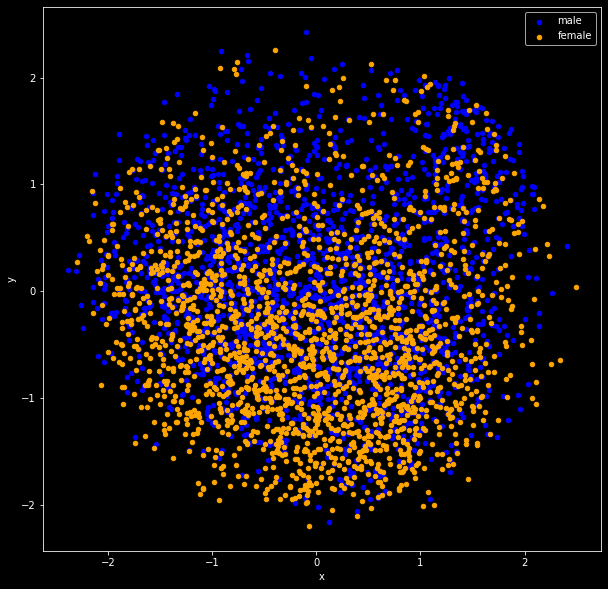

In [135]:
id2gender = {row["user_id"]:row["gender"] for _, row in users.iterrows()}
user_embs_pca["gender"] = user_embs_pca.apply(lambda x:id2gender[x.name], axis=1)

fig, ax = plt.subplots(figsize=(10, 10))
user_embs_pca[user_embs_pca["gender"]=="m"].sample(2000).plot.scatter(ax=ax, x="x", y="y", c="blue", label="male");
user_embs_pca[user_embs_pca["gender"]=="f"].sample(2000).plot.scatter(ax=ax, x="x", y="y", c="orange", label="female");

#### 나이에 따른 취향

In [137]:
id2age = {row["user_id"]:row["age"] for _, row in users.iterrows()}
user_embs_pca["age"] = user_embs_pca.apply(lambda x:id2age[x.name], axis=1)

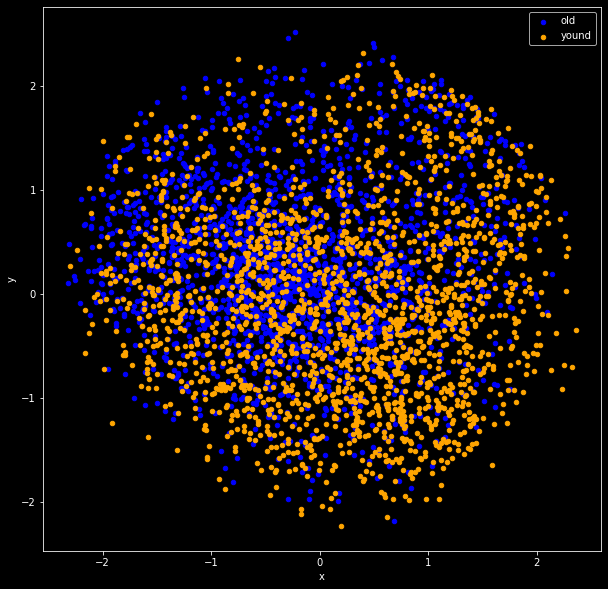

In [141]:
fig, ax = plt.subplots(figsize=(10, 10))
user_embs_pca[user_embs_pca["age"]>=60].sample(2000).plot.scatter(ax=ax, x="x", y="y", c="blue", label="old");
user_embs_pca[user_embs_pca["age"]<=20].sample(2000).plot.scatter(ax=ax, x="x", y="y", c="orange", label="yound");

## Using `annoy`

In [200]:
dim = 61
tree = AnnoyIndex(f=dim, metric="dot")
for i, value in enumerate(item_embs.values):
    tree.add_item(i, value)
tree.build(n_trees=20)

True

### Item-Item Similarity Measure

In [234]:
artist = "beyoncé"
item_vec = item_embs.loc[artist].values

res = tree.get_nns_by_vector(vector=item_vec, n=11, include_distances=True)
display(pd.Series(res[1][1:], index=[id2name[i] for i in res[0][1:]]))

buffy the vampire slayer    4.776211
john guilt                  4.734657
jota quest                  4.681146
mercedes sosa               4.673688
don huonot                  4.641779
pain                        4.606238
apoptygma berzerk           4.542817
keziah jones                4.537165
the bigger lights           4.527881
blackbelt andersen          4.489997
dtype: float64

### User-Item Similarity Measure

In [223]:
user = 209
user_vec = user_embs.loc[user].values

# 이 유저가 어떤 아티스트의 음악을 가장 많이 들었는지 상위 10명
display(plays[plays["user_id"]==user].sort_values(["plays"], ascending=False).iloc[:10])

res = tree.get_nns_by_vector(vector=user_vec, n=10, include_distances=True)
display(pd.Series(res[1], index=[id2name[i] for i in res[0]]))

,user_id,artist_id,artist,plays
10039,209,5393,安室奈美恵,1932
10040,209,1599,浜崎あゆみ,1657
10041,209,545,britney spears,1261
10042,209,5394,12012,1259
10043,209,1597,中島美嘉,926
10044,209,1615,倖田來未,744
10045,209,5395,이효리,738
10046,209,1609,宇多田ヒカル,703
10047,209,353,madonna,660
10048,209,272,michael jackson,589


Центр              4.322185
antichrisis        4.293580
person l           4.248559
reason             4.178973
supersub           4.144037
ade fenton         4.119028
ben et béné        4.108967
platnum            4.062927
merciless death    4.037104
sibel              3.985112
dtype: float64